# Fourier Reconstruction 2D
---
**Notebook 2 — 2026**
<div style="font-size:15px; padding:8px; margin:2px; font-weight:600; background-color:#E80808; color:white;text-align:center;">
    <div style=" ">
        Introduction to Multidimensional Fourier Transform
    </div>
</div>
<div style="border-bottom: 1px gray dotted; padding:8px;margin:2px;text-align:center; font-size:15px; color:#444;">
<i>Daniel Sage — École Polytechnique Fédérale de Lausanne (EPFL)</i>
</div>

**Important notice**: These interactive notebooks complement the lecture and are not self-contained; in-class explanations are required.

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, transform, draw, io
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown
from matplotlib.patches import Circle

def fft2c(x): return np.fft.fftshift(np.fft.fft2(x))
def ifft2c(F): return np.real(np.fft.ifft2(np.fft.ifftshift(F)))
def snr(x,y): return 10*np.log10(np.mean(x*x)/(np.mean((x-y)**2)+1e-12))
def radial_grid(n): a=(np.arange(n)-n//2)/n; X,Y=np.meshgrid(a,a); return np.sqrt(X*X+Y*Y)
def showim(ax,img,t,vmin=None,vmax=None): ax.imshow(img,cmap="gray",vmin=vmin,vmax=vmax); ax.set_title(t); ax.axis("off")
def showFM(ax,F,t): ax.imshow(np.log(np.abs(F)+1e-12),cmap="gray"); ax.set_title(t); ax.axis("off")
def plotsig(ax, x, s, title): ax.plot(x, s); ax.set_title(title); ax.grid(True, lw=.4, color="0.85"); ax.margins(0.01)
def plotFM(ax, x, s, title): rs = np.abs(s)+1e-12; ax.plot(x, rs); ax.set_title(title); ax.set_yscale("log"); ax.grid(True, lw=.4, color="0.85"); ax.margins(0.01)

size=128
img = transform.resize(data.camera(), (size, size), anti_aliasing=True)

In [108]:
def load(choice, n=128):
    sources = {"car_pad": lambda: io.imread("car_pad.tif", as_gray=True), "cell_substrat": 
               lambda: io.imread("cell_substrat.tif", as_gray=True),
               "camera":data.camera, "brick":data.brick, "grass": data.grass,}
    img = sources[choice]()
    return transform.resize(img, (n, n), anti_aliasing=True)

selector = Dropdown(options=["car_pad", "cell_substrat", "camera", "brick", "grass"], description="Image")
def update_img(change): global img; img = load(change["new"])

selector.observe(update_img, names="value")
display(selector)

Dropdown(description='Image', options=('car_pad', 'cell_substrat', 'camera', 'brick', 'grass'), value='car_pad…

## 2.1 Perfect reconstruction

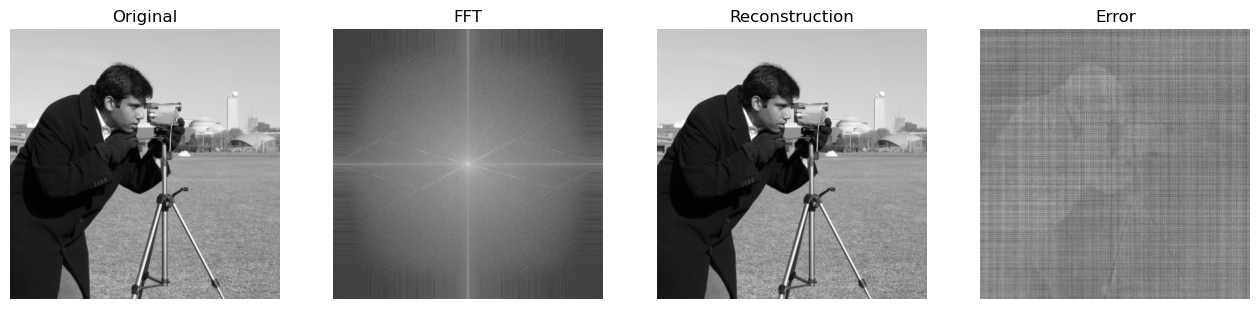

2e-16, SNR=115.30 dB


In [110]:
R=ifft2c(fft2c(img))
fig,ax=plt.subplots(1,4,figsize=(16,4))
showim(ax[0],img,"Original")
showFM(ax[1],fft2c(img),"FFT"); 
showim(ax[2],R,"Reconstruction")
showim(ax[3],img-R,f"Error")
plt.show()
print(f'{np.mean(np.abs(img-R)):3.0e}, SNR={snr(img,R):.2f} dB')

## 2.2 Partial reconstruction (% Non Zero-Coefficients)

In [105]:
F0 = fft2c(img); Rg = radial_grid(size)

@interact(log_nzc=FloatSlider(min=-2, max=0, step=0.05, value=-1), mode=Dropdown(options=["low","high","random","largest"], value="low"))
def partial_reconstruction(log_nzc, mode):
    nzc = 10**log_nzc
    if mode=="low": M = Rg <= nzc * Rg.max()
    elif mode=="high": M = Rg >= (1-nzc) * Rg.max()
    elif mode=="random": M = np.random.rand(size,size) < nzc
    else:
        v = np.abs(F0).ravel(); k = max(1, int(nzc * v.size))
        t = np.partition(v, -k)[-k]; M = np.abs(F0) >= t
    Fm = F0 * M; r = ifft2c(Fm)

    fig,ax = plt.subplots(1,4,figsize=(16,4))
    showim(ax[0], img, "Original")
    showFM(ax[1], F0, f"FFT nzc={(nzc*100):3.1f}%"); ax[1].plot(*np.where(M),'r.',ms=1)
    showim(ax[2], r, f"Recon SNR={snr(img,r):.2f} dB")
    showim(ax[3], img-r, f"Diff {np.linalg.norm(img-r):.2e}")
    plt.show()

interactive(children=(FloatSlider(value=-1.0, description='log_nzc', max=0.0, min=-2.0, step=0.05), Dropdown(d…

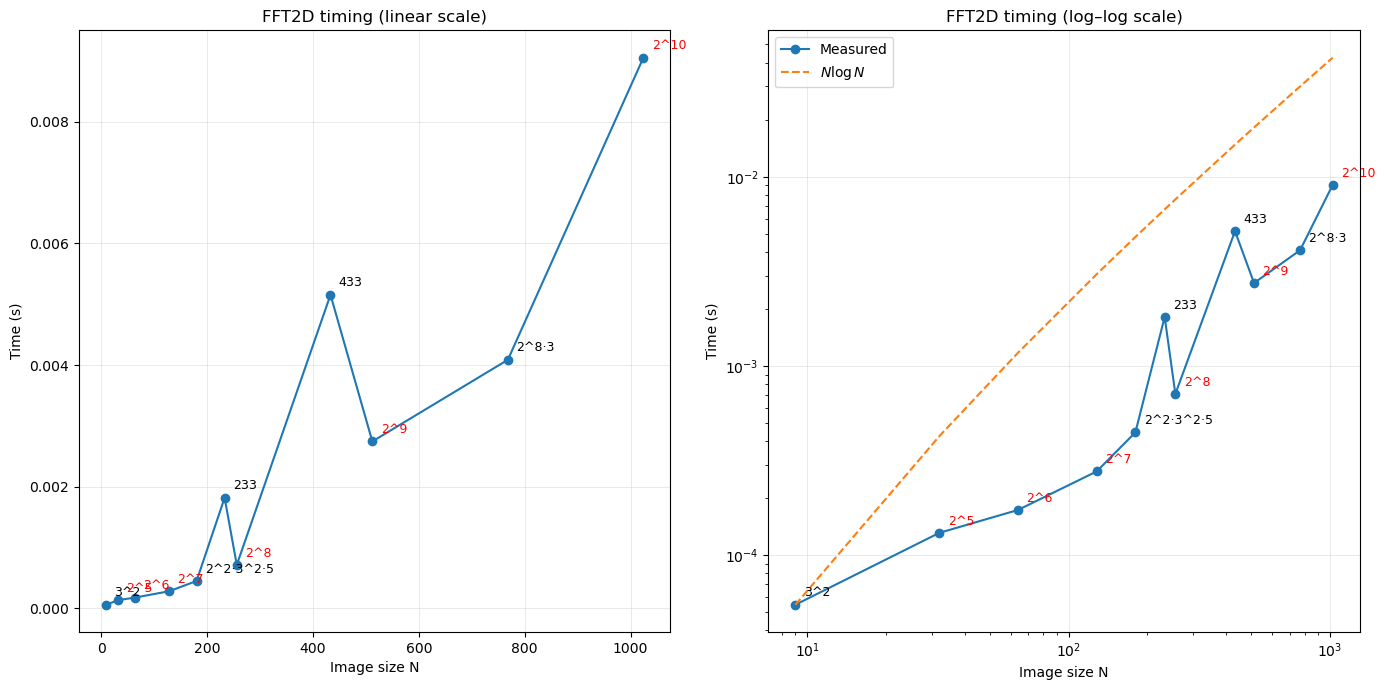

In [106]:
import time
from sympy import factorint

def prime_decomposition_str(n):f = factorint(n); return "·".join(f"{p}^{k}" if k > 1 else f"{p}" for p, k in f.items())
def is_power_of_two(n):return n > 0 and (n & (n - 1)) == 0

sizes = np.array(sorted([9, 32, 64, 512, 1024, 128, 180, 233, 256, 433, 768]))
means = []

for n in sizes:
    img = np.random.rand(n, n)
    t = []
    for _ in range(5): t0 = time.perf_counter(); np.fft.fft2(img); t.append(time.perf_counter() - t0)
    means.append(np.mean(t))
means = np.array(means)

fig, ax = plt.subplots(1, 2, figsize=(14, 7))
ax[0].plot(sizes, means, "o-")
ax[0].set_xlabel("Image size N")
ax[0].set_ylabel("Time (s)")
ax[0].set_title("FFT2D timing (linear scale)")
ax[0].grid(True, lw=0.4, color="0.85")

for x, y in zip(sizes, means):
    ax[0].annotate(prime_decomposition_str(int(x)), (x, y), xytext=(6, 6), textcoords="offset points", fontsize=9, color="red" if is_power_of_two(int(x)) else "black")

ax[1].loglog(sizes, means, "o-", label="Measured")
ax[1].loglog(sizes,means[0] * (sizes / sizes[0]) * np.log2(sizes / sizes[0] + 1),"--",label=r"$N\log N$")
ax[1].set_xlabel("Image size N")
ax[1].set_ylabel("Time (s)")
ax[1].set_title("FFT2D timing (log–log scale)")
ax[1].legend()
ax[1].grid(True, lw=0.4, color="0.85")

for x, y in zip(sizes, means):
    ax[1].annotate(prime_decomposition_str(int(x)), (x, y), xytext=(6, 6), textcoords="offset points",fontsize=9, color="red" if is_power_of_two(int(x)) else "black")

plt.tight_layout()
plt.show()